# Base Model
We would evaluate the performance of the pre-trained base model on full-page images

## Step 1. Data Processing

### 1.1 Load data

In [1]:
import pandas as pd
df_test=pd.read_csv("df_test.csv")
df_train=pd.read_csv("df_train.csv")

In [2]:
df_test.head()

word_id       id    text
0        0  7u2pNft       4
1        1  FXwDU08    Funk
2        2  FXwDU08  adelic
3        3  FXwDU08      or
4        4  FXwDU08   Brain

### 1.2 Convert data into full images

In [3]:
# group words into images
df_test= df_test.groupby('id')['text'].agg(lambda x: ' '.join(map(str, x))).reset_index()

In [4]:
df_test['text']=df_test['text'].astype(str)

In [5]:
df_test.head()

id                                               text
0  01dWS6L  /buns spritE Tomato vanilla cakE 1:45 pm Gift:...
1  01xGl1w  never give up on something you can't go a day ...
2  02gnTwX                              Area- Mixed 2) Shapes
3  03YZwao                                          ck back e
4  04y100y    fields, index. data being n or n: ertain fields

## Step 2. Evaluate

### 2.1 OCRing Testing Dataset

In [6]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
# get base model
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

/common/home/sk2779/courses/cs439/stylized-ocr/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type

In [7]:
image_dataset_path= "dataset/"
def readText(df, idx):
    path= image_dataset_path + df['id'][idx]+ '.jpg'
    image = Image.open(path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [8]:
from tqdm import tqdm
from PIL import Image

In [9]:
def readText_batch(df, indices):
    """Process multiple images at once"""
    paths = [image_dataset_path + df['id'][idx] + '.jpg' for idx in indices]
    images= [Image.open(path).convert("RGB") for path in paths]
    pixel_values = processor(images=images, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)

def process_all_rows_batched(df, batch_size=8):
    results = []
    for i in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        batch_indices = range(i, min(i+batch_size, len(df)))
        try:
            batch_texts = readText_batch(df, batch_indices)
            for idx, text in zip(batch_indices, batch_texts):
                results.append({
                    'id': df['id'][idx],
                    'true_text': df['text'][idx],
                    'predicted_text': text
                })
        except Exception as e:
            print(f"Error in batch {i//batch_size}: {str(e)}")
            for idx in batch_indices:
                results.append({
                    'id': df['id'][idx],
                    'true_text': df['text'][idx],
                    'predicted_text': None,
                    'error': str(e)
                })
    return pd.DataFrame(results)

# Usage (best for GPU utilization)
results_df = process_all_rows_batched(df_test, batch_size=8)

Processing batches: 100%|██████████| 196/196 [40:36<00:00, 12.43s/it]


In [10]:
results_df.head(5)

id                                          true_text  \
0  01dWS6L  /buns spritE Tomato vanilla cakE 1:45 pm Gift:...   
1  01xGl1w  never give up on something you can't go a day ...   
2  02gnTwX                              Area- Mixed 2) Shapes   
3  03YZwao                                          ck back e   
4  04y100y    fields, index. data being n or n: ertain fields   

            predicted_text  
0                      2 1  
1                      0 1  
2  changes and accessories  
3                   police  
4            the following

In [11]:
# to analyze character difference rate, remove all the spaces into one token
results_df["pred"]= results_df["predicted_text"].str.replace(' ', '')
results_df["label"]= results_df["true_text"].str.replace(' ', '')

### 2.2 Evaluate Metric

In [12]:
from collections import defaultdict
import numpy as np

def levenshtein_distance(s1, s2):
    """Compute Levenshtein distance iteratively (no recursion)."""
    m, n = len(s1), len(s2)
    dp = [[0] * (n + 1) for _ in range(m + 1)]  # DP table
    
    # Initialize base cases
    for i in range(m + 1):
        dp[i][0] = i  # Cost to delete all chars in s1[:i]
    for j in range(n + 1):
        dp[0][j] = j  # Cost to insert all chars in s2[:j]
    
    # Fill DP table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if s1[i - 1] == s2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]  # No cost if chars match
            else:
                dp[i][j] = min(
                    dp[i - 1][j] + 1,     # Deletion
                    dp[i][j - 1] + 1,     # Insertion
                    dp[i - 1][j - 1] + 1  # Substitution
                )
    return dp[m][n]

def compute_metrics(pred_str, label_str):
    distance= levenshtein_distance(pred_str, label_str)
    # number of edits relative to total number of char in label
    cer = distance / len(label_str) if len(label_str) != 0 else 0.0 
    return cer

### 2.3 Evaluate

In [13]:
results_df["metrics"] = results_df.apply(
    lambda row: compute_metrics(row["pred"], row["label"]),
    axis=1
)

## Step 3. Analyze Performance

### 3.1 Metric Summary

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

def plot_eval(values):
    # Plotting
    plt.figure(figsize=(8, 5))
    sns.kdeplot(values, shade=True)
    plt.xlabel("Edit Distance")
    plt.title("KDE of Edit Distances")
    plt.show()
        
    # Boxplot
    plt.boxplot(values, vert=False, patch_artist=True)
    plt.xlabel("Edit Distance")
    plt.title("Boxplot of Edit Distances")
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1273712/805715199.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(values, shade=True)


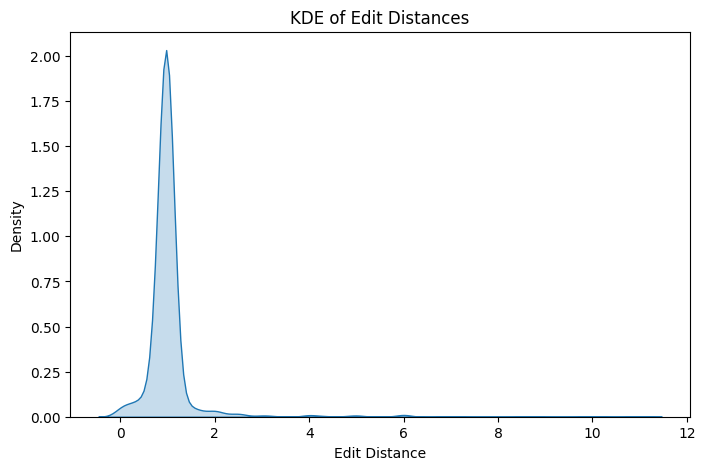

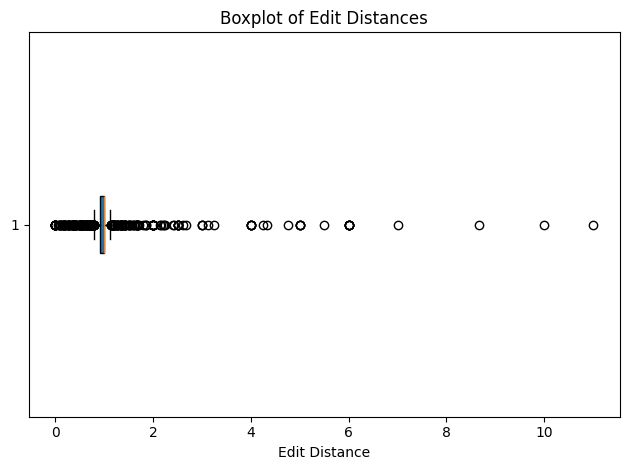

In [17]:
plot_eval(results_df["metrics"])

In [20]:
def show_state(values):
    stats = {
        "mean": np.mean(values),
        "median": np.median(values),
        "std": np.std(values),
        "min": np.min(values),
        "max": np.max(values),
        "quantiles": np.quantile(values, [0.25, 0.5, 0.75]),
    }
    
    # 3. Print results
    print("Summary Statistics:")
    print(f"- Mean ± Std: {stats['mean']:.2f} ± {stats['std']:.2f}")
    print(f"- Median (IQR): {stats['median']:.2f} ({stats['quantiles'][0]:.2f}–{stats['quantiles'][2]:.2f})")
    print(f"- Range: [{stats['min']}, {stats['max']}]")
    print(f"- Quantiles (25th, 50th, 75th): {stats['quantiles'].round(2)}")

In [21]:
show_state(results_df["metrics"])

Summary Statistics:
- Mean ± Std: 1.04 ± 0.68
- Median (IQR): 0.99 (0.92–1.00)
- Range: [0.0, 11.0]
- Quantiles (25th, 50th, 75th): [0.92 0.99 1.  ]


#### Oberservation
The character error rate (CER) remains close to 1, indicating that the base model fails to recognize most of the text, requiring significant corrections. This result is expected, as the model was originally trained on single-line text and struggles with full-page documents.

### 3.2 Success Cases

In [29]:
success_cases = results_df[results_df["metrics"]<0.3]

In [32]:
print("number of success cases", len(success_cases), " percent", len(success_cases)/len(results_df))

number of success cases 43  percent 0.027476038338658148


In [38]:
success_cases.head()

id             true_text          predicted_text  \
70   34ids7q                before                before .   
138  5cygpF6               Radical                 Radical   
140  5eZ5IMK               reality                 reality   
159  6M0FJH9               3/17/14                 3p17114   
182  7Fsi14W  #stop killing rhinos  westaphilling rhinos .   

                     pred               label   metrics  
70                before.              before  0.166667  
138               Radical             Radical  0.000000  
140               reality             reality  0.000000  
159               3p17114             3/17/14  0.285714  
182  westaphillingrhinos.  #stopkillingrhinos  0.277778

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
import math

def read_image(path):
    """Read an image from the given path and convert to RGB."""
    return Image.open(path).convert("RGB")

def display_images_grid(indices, image_dataset_path, images_per_row=4):
    """
    Display images in a grid (4 per row), automatically arranging into multiple rows if needed.
    
    Args:
        indices (list): List of image indices (e.g., [1, 2, 3, 4, 5, ...]).
        image_dataset_path (str): Path to the folder containing images.
        images_per_row (int): Number of images per row (default: 4).
    """
    assert image_dataset_path is not None, "Path to image dataset not set!"
    
    total_images = len(indices)
    num_rows = math.ceil(total_images / images_per_row)
    
    # Create a grid with dynamic rows
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 5 * num_rows))
    fig.tight_layout()
    
    # Flatten axes if only 1 row to simplify indexing
    if num_rows == 1:
        axes = [axes]
    
    for i, index in enumerate(indices):
        row = i // images_per_row
        col = i % images_per_row
        
        # Read image
        img_path = f"{image_dataset_path}/{index}.jpg"
        try:
            img = read_image(img_path)
            # Display image
            if num_rows == 1:
                axes[col].imshow(img)
                axes[col].set_title(f"Image {index}")
                axes[col].axis('off')
            else:
                axes[row][col].imshow(img)
                axes[row][col].set_title(f"Image {index}")
                axes[row][col].axis('off')
        except FileNotFoundError:
            print(f"Image {index}.jpg not found. Skipping...")
    
    # Hide empty subplots
    for i in range(total_images, num_rows * images_per_row):
        row = i // images_per_row
        col = i % images_per_row
        if num_rows == 1:
            axes[col].axis('off')
        else:
            axes[row][col].axis('off')
    
    plt.show()

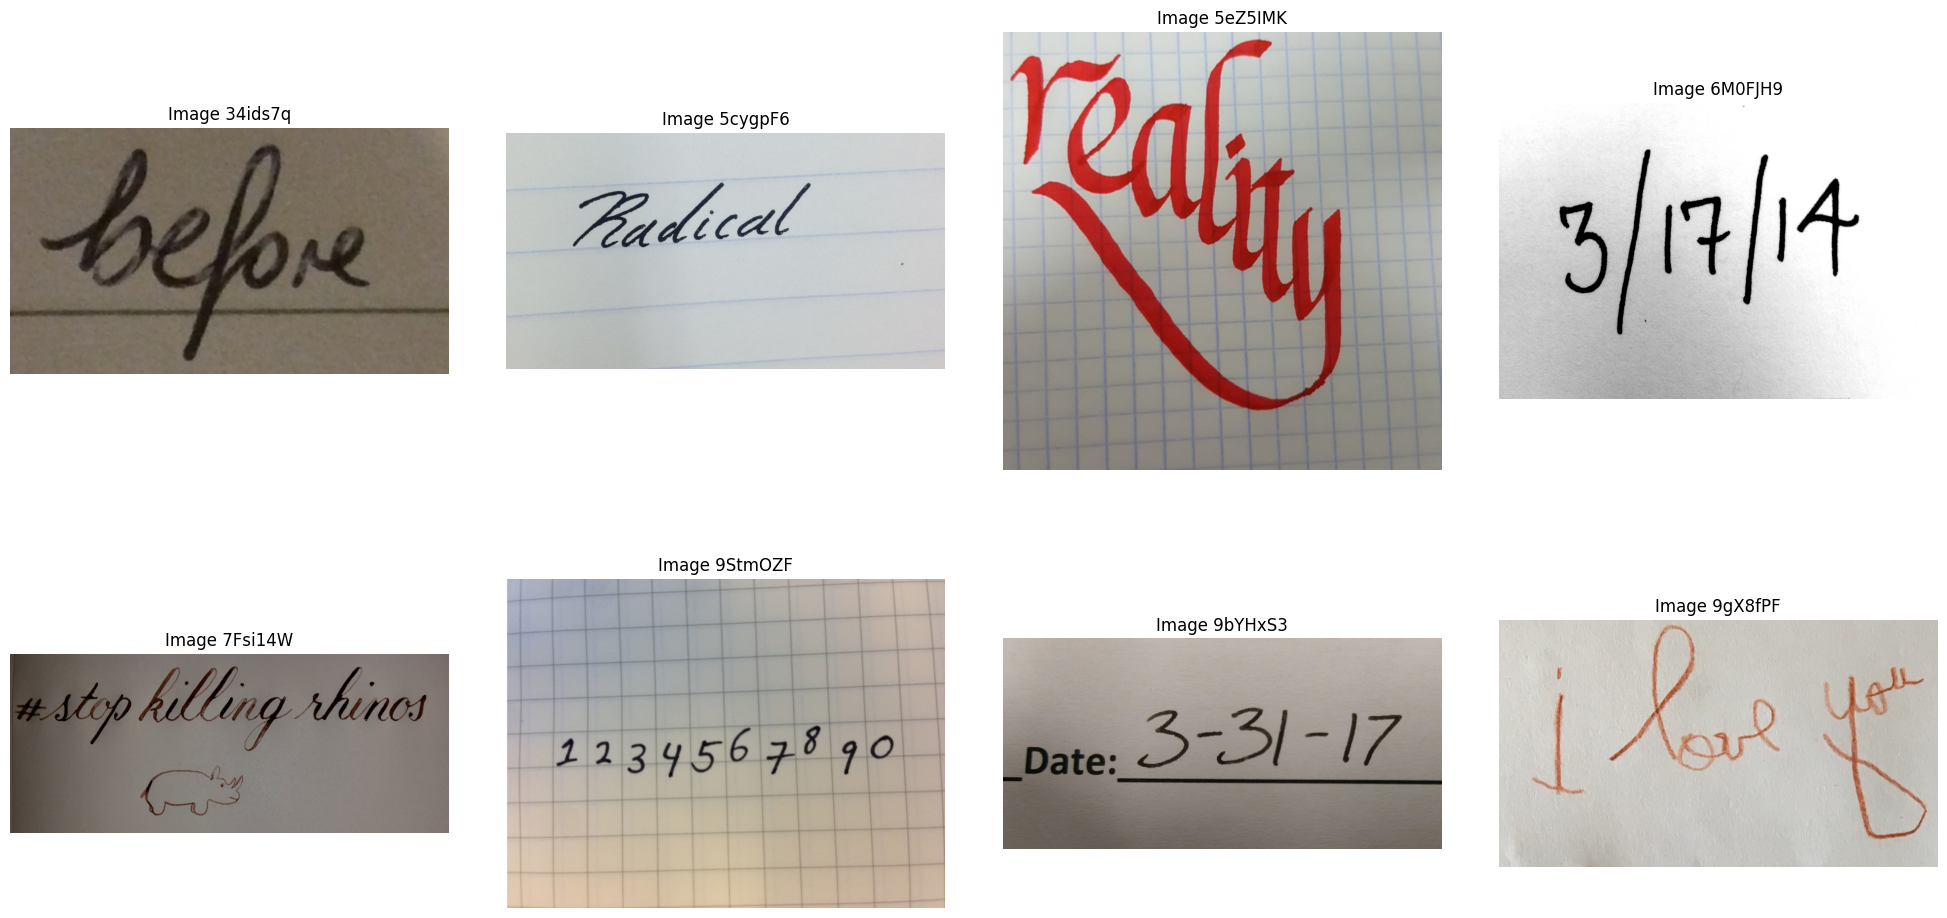

In [39]:
# print out the 8 success cases
indices= success_cases["id"][:8]
display_images_grid(indices, image_dataset_path, images_per_row=4)

#### Observation
The base model demonstrates strong performance in recognizing horizontally aligned text, and surprisingly, it also handles some degree of tilts effectively. However, this capability is primarily observed in short text segments—particularly single words or brief phrases—where structural complexity is minimal.

### 3.3 Outliers 
There are some outlier there have extremely high cer rate

In [41]:
outliers = results_df[results_df["metrics"]>4]

In [42]:
print("number of success cases", len(outliers), " percent", len(outliers)/len(results_df))

number of success cases 18  percent 0.011501597444089457


In [43]:
outliers.head()

id true_text    predicted_text           pred label  metrics
123  52qBSO3         M      5 References    5References     M     11.0
169  6f3R7fS         B            priory         priory     B      6.0
341  DrpxIky         P       exeteries .     exeteries.     P     10.0
439  Hpe2fsc        V.  2 1 . Visualists  21.Visualists    V.      6.0
595  OGwMNhK         a           veigh .         veigh.     a      6.0

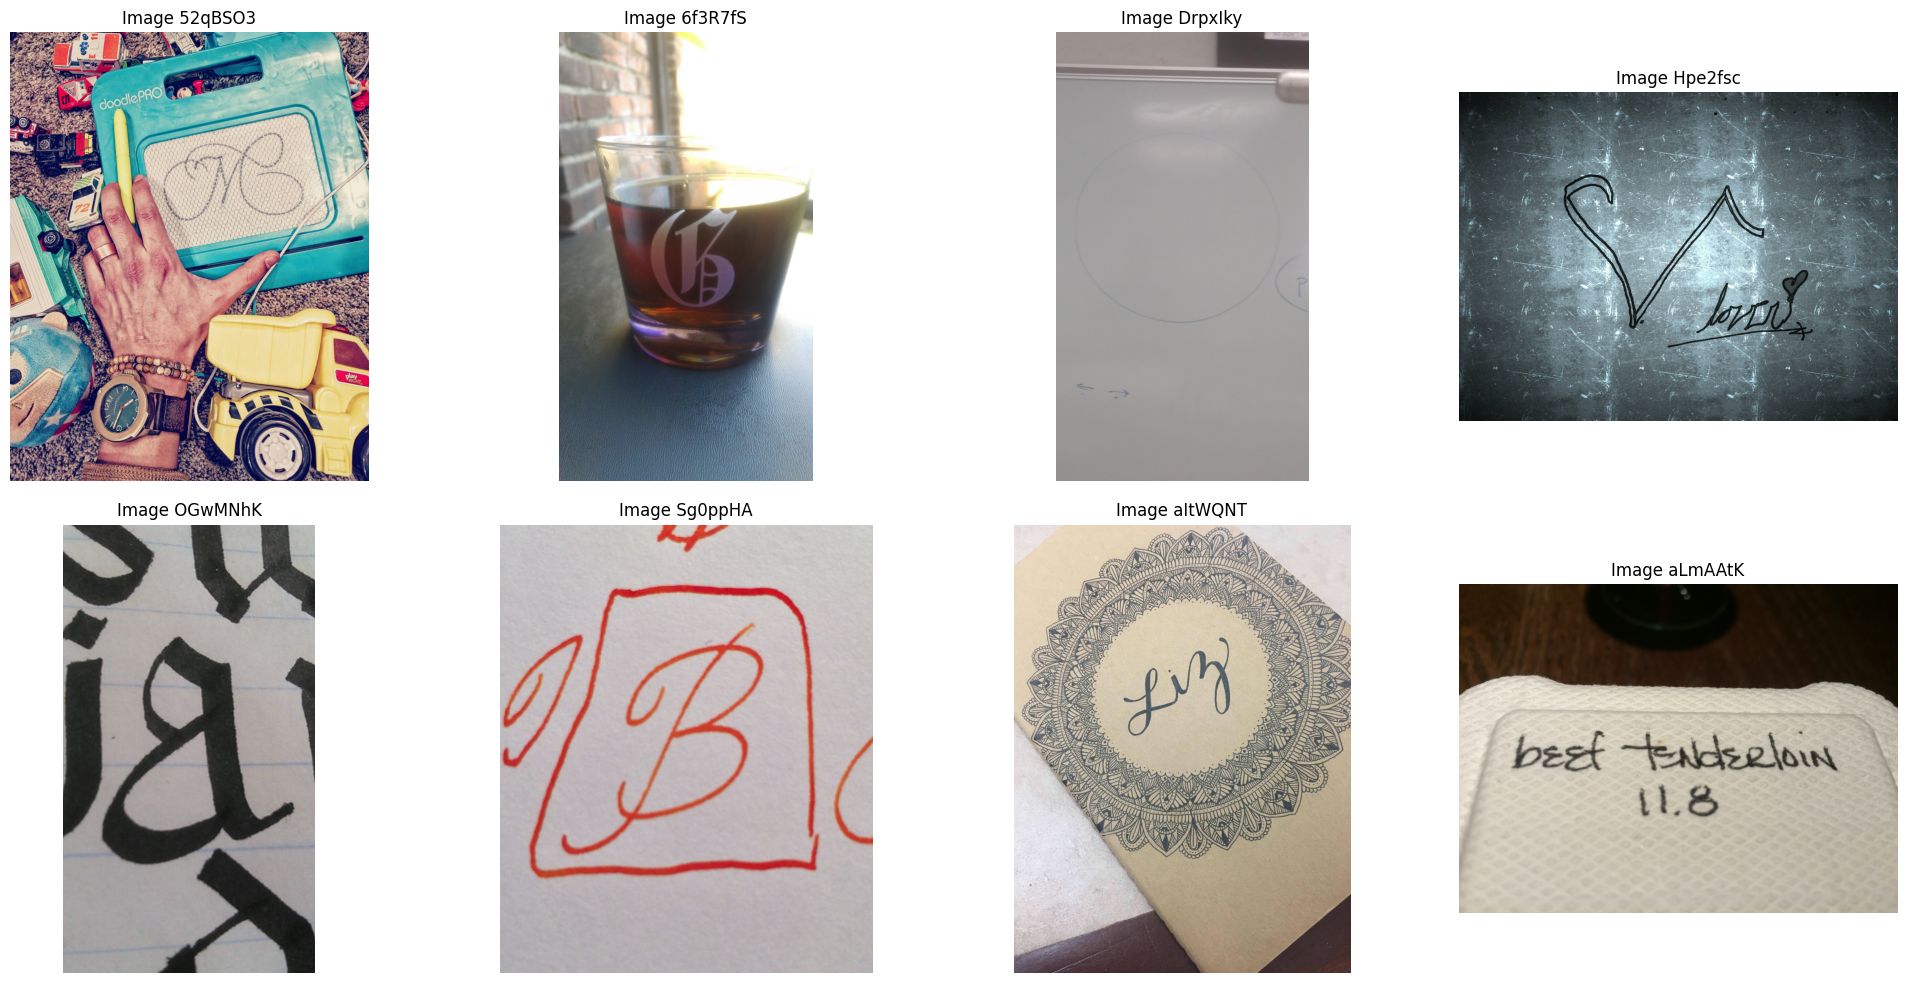

In [44]:
# print out outliers
indices= outliers["id"][:8]
display_images_grid(indices, image_dataset_path, images_per_row=4)

#### Observation
The base model exhibits significant difficulty in distinguishing textual content from visual noise, frequently misclassifying artifacts as valid characters. This limitation underscores its lack of robustness in handling noisy or stylized documents.
To address this issue, we propose fine-tuning the model on a dataset incorporating structured noise and varied typographic styles, which we would test in the next step.